# Comparison pvlib vs pvsyst

## Libraries import

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import copy

## Global variables

In [109]:
k_Boltzmann = 1.381 / (10 ** 23) # J/K
q_electron = 1.602 / (10 ** 19) # C


pvsyst_SolarWorld_Sunmodule_250_Poly__2013 = {
#The short-circuit current temperature coefficient of the module in units of A/C.
# muIsc  (often named Alpha)
"alpha_sc" : 2.9 / (10**3), 
#The diode ideality factor 
"gamma_ref" : 0.94, 
# The temperature coefficient for the diode ideality factor, 1/K
# using 2nd value comparing in the diode ideality factor 
"mu_gamma" : -0.001, 
#The light-generated current (or photocurrent) at reference conditions, in amperes.
# using Isc for I_L_ref
"I_L_ref" : 8.640, 
#The dark or diode reverse saturation current at reference conditions, in amperes.
"I_o_ref" : 0.046 / (10 ** 9), 
#The shunt resistance at reference conditions, in ohms.
"R_sh_ref" : 300, 
#The shunt resistance at zero irradiance conditions, in ohms.
"R_sh_0" : 1200, 
#The series resistance at reference conditions, in ohms.
# series model
"R_s" : 0.3, 
#The number of cells connected in series.
"cells_in_series" : 60, 
#The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
# PVsyst: this value is set as default value ... Navigation:  Physical models used > PV Module - Standard one-diode-model >
"R_sh_exp" : 5.5, 
#The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
"EgRef" : 1.12, #1, #tried also with suggested 1.121 , no sensible changes
# Reference irradiance in W/m^2.
"irrad_ref" : 1000, 
"temp_ref" : 25
}


pvsyst_SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_250_poly = {
"alpha_sc" : 4.4 / (10**3), # muIsc  (often named Alpha)
"gamma_ref" : 0.961,  #The diode ideality factor 
"mu_gamma" : - 0.00, #04 # replaced 0 (?!!) # The temperature coefficient for the diode ideality factor, 1/K
"I_L_ref" : 8.810, # using Isc 
"I_o_ref" : 0.050 / (10 ** 9), #The dark or diode reverse saturation current at reference conditions, in amperes.
"R_sh_ref" : 240, #The shunt resistance at reference conditions, in ohms.
"R_sh_0" : 1000, #The shunt resistance at zero irradiance conditions, in ohms.
"R_s" : 0.35, #The series resistance at reference conditions, in ohms.
 #same as pvsyst_SolarWorld_Sunmodule_250_Poly__2013 :
"cells_in_series" : 60, 
"R_sh_exp" : 5.5, # The exponent in the equation for shunt resistance
"EgRef" : 1.12, # The energy bandgap at reference temperature in units of eV. 1.121 eV
"irrad_ref" : 1000,  # Reference irradiance in W/m^2.
"temp_ref" : 25    
}



# %%
ps_prms = pvsyst_SolarWorld_Sunmodule_250_Poly__2013
ps_prms = pvsyst_SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_250_poly

modules = pvlib.pvsystem.retrieve_sam('CECmod')
ps_prms_cec = modules['SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_250_poly']


In [110]:
ps_prms

{'alpha_sc': 0.0044,
 'gamma_ref': 0.961,
 'mu_gamma': 0.0,
 'I_L_ref': 8.81,
 'I_o_ref': 5e-11,
 'R_sh_ref': 240,
 'R_sh_0': 1000,
 'R_s': 0.35,
 'cells_in_series': 60,
 'R_sh_exp': 5.5,
 'EgRef': 1.12,
 'irrad_ref': 1000,
 'temp_ref': 25}

In [111]:
ps_prms_cec

Technology           Multi-c-Si
Bifacial                      0
STC                     250.096
PTC                       224.7
A_c                         1.6
Length                    1.645
Width                      0.97
N_s                          60
I_sc_ref                   8.64
V_oc_ref                   37.6
I_mp_ref                   8.12
V_mp_ref                   30.8
alpha_sc               0.007171
beta_oc               -0.146264
T_NOCT                     46.6
a_ref                  1.642697
I_L_ref                8.644163
I_o_ref                     0.0
R_s                    0.245666
R_sh_ref             509.875793
Adjust                 1.600486
gamma_r                   -0.45
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_250_poly, dtype: object

## Wrap-up functions

In [112]:
def get_iv(df:pd.DataFrame, ps_prms:dict, calcparams="desoto", ivcurve_pnts=400,
           cecmodule='SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_250_poly',
           k_Boltzmann= , * 298.16 /, q_electron=) -> pd.DataFrame:
    """
    wrap-up function
    :param df:
    :param x: dataframe dictionary
    :param ps_prms: parameters dictionary 
    :param calcparams: "desoto" or "pvsyst"
    :param calcmp: "singlediode", "bishop88"
    :param method: 'lambertw' #, 'newton', or 'brentq'
    :param ivcurve_pnts: 
    :param cecmodule: 
    :return: df with additional columns (see below). i & v as array for each point.
    """ 
    # using the ones from pvsyst instead of pvlib
    temp_cell = "TArray"
    effective_irradiance = "GlobEff"
    # no need to order
    clms_sd = ["photocurrent","saturation_current","resistance_series","resistance_shunt","nNsVth"]
    clms = ["i_sc","v_oc","i_mp","v_mp","p_mp","i_x","i_xx"]
    if ivcurve_pnts > 0: clms = clms + ["v","i"]

    if calcparams == "desoto":
        df[clms_sd] = df.apply(
        lambda x:                 
        pvlib.pvsystem.calcparams_desoto(
        effective_irradiance = x[effective_irradiance], 
        temp_cell = x[temp_cell], 
        alpha_sc = ps_prms["alpha_sc"], #The short-circuit current temperature coefficient of the module in units of A/C.
        a_ref =  ps_prms["gamma_ref"] * ps_prms["cells_in_series"] * k_Boltzmann * 298.16 / q_electron,
        # The product of the usual diode ideality factor (n, unitless), number of cells in series (Ns), and cell thermal voltage at reference conditions, in units of V        
        # {\displaystyle V_{\text{T}}=kT/q,} the thermal voltage.
        # gamma_ref = ps_prms["gamma_ref"], #The diode ideality factor
        # mu_gamma = ps_prms["mu_gamma"], #The temperature coefficient for the diode ideality factor, 1/K
        I_L_ref = ps_prms["I_L_ref"], #The light-generated current (or photocurrent) at reference conditions, in amperes.
        I_o_ref = ps_prms["I_o_ref"], #The dark or diode reverse saturation current at reference conditions, in amperes.
        R_sh_ref = ps_prms["R_sh_ref"], #The shunt resistance at reference conditions, in ohms.
        # R_sh_0 = ps_prms["R_sh_0"], #The shunt resistance at zero irradiance conditions, in ohms.
        R_s = ps_prms["R_s"], #The series resistance at reference conditions, in ohms.
        # cells_in_series = ps_prms["cells_in_series"], #The number of cells connected in series.
        #R_sh_exp=ps_prms["R_sh_exp"], #The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
        dEgdT= - 0.0002677, #The temperature dependence of the energy bandgap at reference conditions in units of 1/K
        EgRef=ps_prms["EgRef"], #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
        irrad_ref=ps_prms["irrad_ref"], # Reference irradiance in W/m^2.
        temp_ref=ps_prms["temp_ref"] # Reference cell temperature in C.
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms_sd,[np.nan]*len(clms_sd)))), 
        axis=1, result_type='expand')

    # version 0.93, PVsyst v6 model
    elif calcparams == "pvsyst":
        df[clms_sd] = df.apply(lambda x:                 
        pvlib.pvsystem.calcparams_pvsyst(
        effective_irradiance = x[effective_irradiance], 
        temp_cell = x[temp_cell], 
        alpha_sc = ps_prms["alpha_sc"], #The short-circuit current temperature coefficient of the module in units of A/C.
        gamma_ref = ps_prms["gamma_ref"], #The diode ideality factor
        mu_gamma = ps_prms["mu_gamma"], #The temperature coefficient for the diode ideality factor, 1/K
        I_L_ref = ps_prms["I_L_ref"], #The light-generated current (or photocurrent) at reference conditions, in amperes.
        I_o_ref = ps_prms["I_o_ref"], #The dark or diode reverse saturation current at reference conditions, in amperes.
        R_sh_ref = ps_prms["R_sh_ref"], #The shunt resistance at reference conditions, in ohms.
        R_sh_0 = ps_prms["R_sh_0"], #The shunt resistance at zero irradiance conditions, in ohms.
        R_s = ps_prms["R_s"], #The series resistance at reference conditions, in ohms.
        cells_in_series = ps_prms["cells_in_series"], #The number of cells connected in series.
        R_sh_exp=ps_prms["R_sh_exp"], #The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
        EgRef=ps_prms["EgRef"], #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
        irrad_ref=ps_prms["irrad_ref"], # Reference irradiance in W/m^2.
        temp_ref=ps_prms["temp_ref"] # Reference cell temperature in C.
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms_sd,[np.nan]*len(clms_sd)))), 
        axis=1, result_type='expand')

    elif calcparams == "cecmod":
        modules = pvlib.pvsystem.retrieve_sam('CECmod')       
        swmod = modules[cecmodule]
        df[clms_sd] = df.apply(lambda x:                 
        pvlib.pvsystem.calcparams_cec(
        effective_irradiance = x[effective_irradiance], 
        temp_cell = x[temp_cell],       
        alpha_sc = ps_prms_cec["alpha_sc"], #The short-circuit current temperature coefficient of the module in units of A/C.
        a_ref = ps_prms["gamma_ref"] * ps_prms["cells_in_series"] * k_Boltzmann * 298.16 / q_electron,
        I_L_ref = ps_prms_cec["I_L_ref"], #The light-generated current (or photocurrent) at reference conditions, in amperes.
        I_o_ref = ps_prms_cec["I_o_ref"], #The dark or diode reverse saturation current at reference conditions, in amperes.
        R_sh_ref = ps_prms_cec["R_sh_ref"], #The shunt resistance at reference conditions, in ohms.
        R_s = ps_prms_cec["R_s"], #The series resistance at reference conditions, in ohms.
        Adjust = ps_prms_cec["Adjust"]
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms_sd,[np.nan]*len(clms_sd)))), 
        axis=1, result_type='expand')


    df[clms] = df.apply(lambda x:                 
    pvlib.pvsystem.singlediode(
    photocurrent = x["photocurrent"],
    saturation_current = x["saturation_current"],
    resistance_series = x["resistance_series"],
    resistance_shunt = x["resistance_shunt"],
    nNsVth = x["nNsVth"], # k_Boltzmann * x[temp_cell] / q_electron
    ivcurve_pnts = ivcurve_pnts,
    method = "lambertw"
    ) if x[effective_irradiance] != 0 else
    pd.Series(dict(zip(clms,[np.nan]*len(clms))))
    , axis=1, result_type='expand')
    # not clear why array returned
    df["i_mp"]=df["i_mp"].apply(float)
    df["v_mp"]=df["v_mp"].apply(float)

    return df

In [113]:
def plot_iv_curves(irradiance: list, temperature:list, calcparams = "desoto") -> pd.DataFrame:
    plt.close()
    fig,ax1 = plt.subplots()
    calccmp ="singlediode"
    title = f"IV curves (parameters {calcparams}, mpp {calccmp})"
    iv_conditions = pd.DataFrame({"GlobEff":irradiance,"TArray":temperature})
    iv_curves = get_iv(iv_conditions, ps_prms, calcparams)         
    for k, r in iv_curves.iterrows():
        l = "_".join(["GlobEff",str(r["GlobEff"]),"TArray",str(r["TArray"])])
        ax1.plot(r["v"], r["i"], label=l, alpha=0.7)
    ax1.set_title(title)
    ax1.set_xlabel('v')
    ax1.set_ylabel('i')
    ax1.legend()
    return iv_curves

## I/V curves plotting

In [114]:
calcparamss = ["desoto", "pvsyst"]
calccmp = "singlediode"

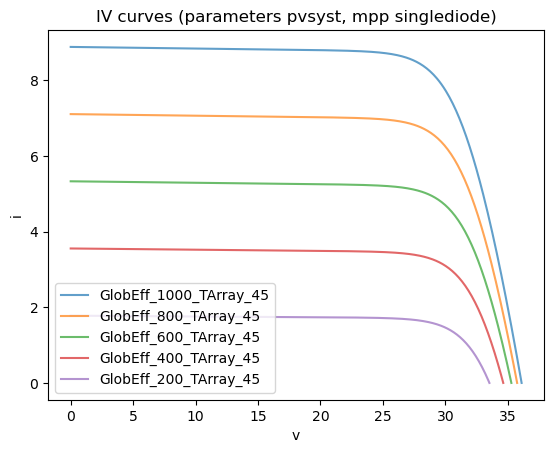

In [115]:
iv_curves = plot_iv_curves(irradiance = [1000,800,600,400,200], temperature = [45]*5,
                            calcparams="pvsyst")
iv_curves.to_csv("iv_curves_pvsyst_t45.csv")

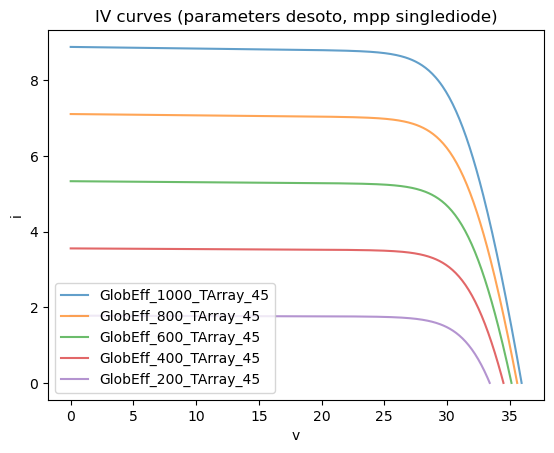

In [116]:
iv_curves = plot_iv_curves(irradiance = [1000,800,600,400,200], temperature = [45]*5,
                            calcparams="desoto")
iv_curves.to_csv("iv_curves_desoto_t45.csv")

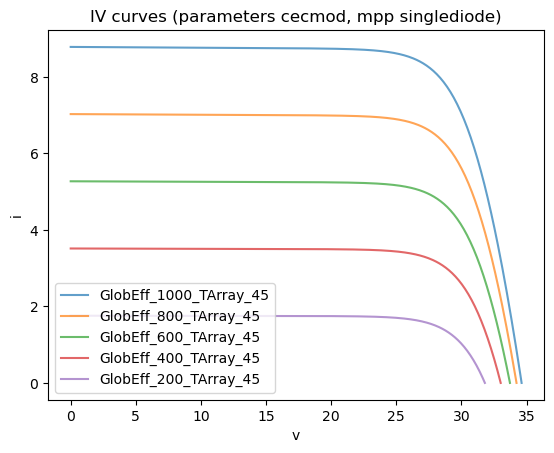

In [117]:
iv_curves = plot_iv_curves(irradiance = [1000,800,600,400,200], temperature = [45]*5,
                            calcparams="cecmod")
iv_curves.to_csv("iv_curves_cecmod_t45.csv")

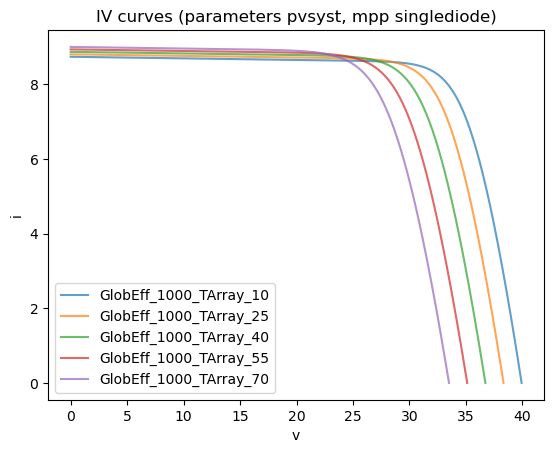

In [70]:
iv_curves = plot_iv_curves(irradiance = [1000]*5, temperature = [10,25,40,55,70],
                            calcparams="pvsyst")
iv_curves.to_csv("iv_curves_pvsyst_i1000.csv")

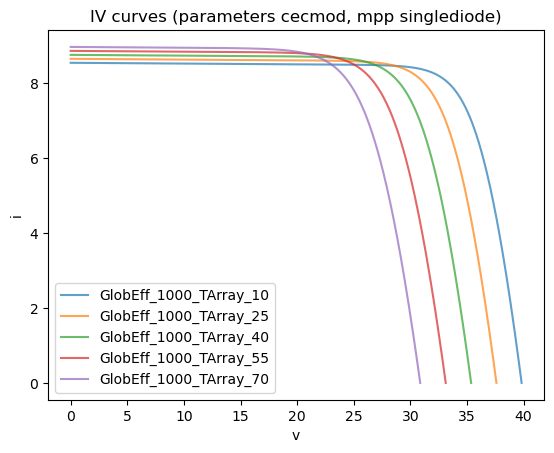

In [118]:
iv_curves = plot_iv_curves(irradiance = [1000]*5, temperature = [10,25,40,55,70],
                            calcparams="cecmod")
iv_curves.to_csv("iv_curves_cecmod_i1000.csv")

In [ ]:
iv_curves = plot_iv_curves(irradiance = [1000]*5, temperature = [10,25,40,55,70],
                            calcparams="pvsyst")
iv_curves.to_csv("iv_curves_pvsyst_i1000.csv")